In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(True)

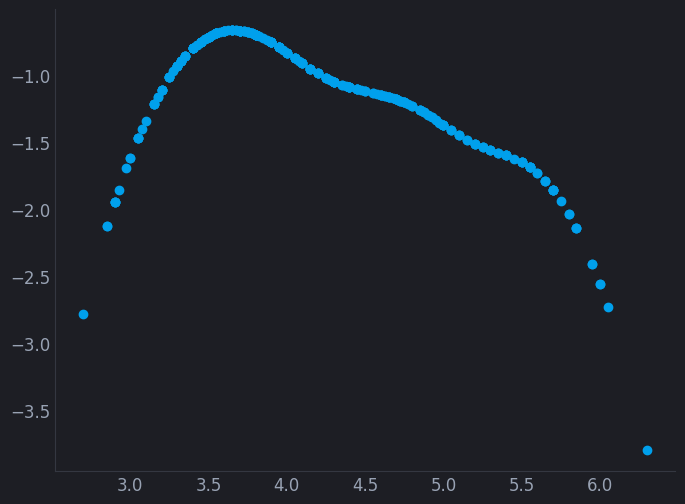

In [2]:
from scipy import stats
df = sns.load_dataset('penguins')
df['body_mass_kg'] = df['body_mass_g'] / 1000
df_xx = df['body_mass_kg'].dropna()
df_yy = np.log(stats.gaussian_kde(df_xx)(df_xx))

plt.scatter(df_xx, df_yy)

In [3]:
import pyro
import pyro.distributions as dists
from pyro.distributions.torch_distribution import TorchDistributionMixin
import pyro.distributions.constraints as constrs
import pyro.distributions.transforms as transforms
import torch

dist = dists.SoftAsymmetricLaplace

params = sorted(dist.arg_constraints)

def to_np(tt: torch.Tensor) -> np.ndarray:
    return tt.detach().cpu().numpy()

In [8]:
def prior_dist(constr, scale=1):
    if isinstance(constr, type(constrs.real)):
        return dists.Normal(0, 2 * scale)
    elif isinstance(constr, constrs.interval):
        lb, ub = constr.lower_bound, constr.upper_bound
        loc = lb
        scale = ub - lb
        return dists.AffineBeta(3, 3, loc, scale)
    elif isinstance(constr, (constrs.greater_than, constrs.greater_than_eq)):
        lb = constr.lower_bound
        return dists.TransformedDistribution(
            dists.Exponential(1 / scale),
            [dists.transforms.AffineTransform(lb, 1)])
    else:
        print(f'No custom value for {constr}')
        return dists.TransformedDistribution(
            prior_dist(constr.real, scale),
            [dists.transforms.transform_to(constr)]
        )

class ParamSpace:
    """Parameter space for a nonlinear regression problem."""
    def __init__(
        self,
        theta_constraints,
        n_groups = 7,
        n_samples = 20,
        scale=1):
        self.theta_transforms = {
            param: transforms.transform_to(constr)
            for param, constr in theta_constraints.items()
        }
        self.param_names = list(self.theta_transforms)
        self.n_groups = n_groups
        self.n_samples = n_samples
        self.n_params = len(theta_constraints)
        self.param_dists = [prior_dist(constr, scale) for constr in theta_constraints.values()]
        self.fixed_values = [None for _ in range(self.n_params)]
        self._initialize_space()

    def _initialize_space(self):
        self.group_levels = []
        samples_shape = (self.n_params, self.n_groups, self.n_samples, self.n_params)
        raw_samples = torch.stack([
            param_dist.sample([self.n_samples]) for param_dist in self.param_dists
        ], dim=-1)
        self.samples = raw_samples.unsqueeze(0).expand(samples_shape).clone()
        for i, param_dist in enumerate(self.param_dists):
            levels = param_dist.icdf(torch.linspace(0, 1, self.n_groups + 2)[1:-1])
            self.group_levels.append(levels)
            self.samples[i, :, :, i] = levels.unsqueeze(0).expand((self.n_samples, self.n_groups)).T.clone()


    def fix(self, param, value):
        if isinstance(param, str):
            param = self.param_names.index(param)
        else:
            param = int(param)

        self.fixed_values[param] = value

    def unfix(self, param):
        if isinstance(param, str):
            param = self.param_names.index(param)
        else:
            param = int(param)

        self.fixed_values[param] = None

    def free_sample_space(self):
        samples = self.samples.clone()
        free_vars = []
        for i, value in enumerate(self.fixed_values):
            if value is None:
                free_vars.append(i)
            else:
                samples[..., i] = value
        return samples[free_vars, ...], [self.param_names[i] for i in free_vars], free_vars


def expected_value(func):
    def e_f(x, log_y):
        # return (func(x) * torch.softmax(log_y, dim=-1).nan_to_num(0)).sum(dim=-1, keepdim=True)
        ii = torch.argsort(x, dim=-1)
        x = x.gather(-1, ii)
        log_y = log_y.gather(-1, ii)
        area = torch.log(torch.trapezoid(torch.exp(log_y), x)).unsqueeze(-1)
        avg = (func(x) * torch.softmax(torch.clip(log_y, -30, 30), -1)).sum(dim=-1)
        log_y = log_y - area
        trap = torch.trapezoid(func(x) * torch.exp(log_y), x)
        trap[trap.isnan()] = avg[trap.isnan()]
        return trap
    return e_f

mean = expected_value(lambda x: x)

def std(x, log_y):
    mu = mean(x, log_y)
    x_diff = x - mu.unsqueeze(-1)
    return torch.sqrt(expected_value(torch.square)(x_diff, log_y))

def mode(x, log_y):
    return x.gather(-1, torch.argmax(log_y, dim=-1, keepdim=True))[..., 0]


# test_xx = torch.linspace(0, 50, 1000)
# test_dist = dists.Gamma(10, 1)
# test_yy = test_dist.log_prob(test_xx)

# plt.plot(to_np(test_xx), to_np(torch.exp(test_yy)))
# print(torch.sqrt(test_dist.variance))
# std(test_xx, test_yy)


from torch.nn import Module

def dist_as_target(dist_name):
    if isinstance(dist_name, str):
        dist = getattr(dists, dist_name)
    else:
        dist = dist_name

    class DistTarget(Module):
        def __init__(self, theta):
            super().__init__()
            self.dist = dist
            self.theta = theta
            self.frozen = self.dist(*[self.theta[..., i] for i in range(self.theta.shape[-1])])

        def forward(self, x: torch.Tensor):
            for _ in range(len(self.frozen.batch_shape)):
                x = x.unsqueeze(-1)

            y = self.frozen.expand_by(x.shape[:1]).log_prob(x)
            x = x.expand_as(y)

            x, y = torch.moveaxis(x, 0, -1), torch.moveaxis(y, 0, -1)
            return (x, y)

    return DistTarget


dist = dists.AffineBeta
f = dist_as_target(dist)
n_test = 100
space = ParamSpace(dist.arg_constraints, n_groups=5, scale=2)
# space.fix('scale', 0)
# space.fix('asymmetry', 0.3)
# raw_x = dists.Normal(4.5, 1).icdf(torch.linspace(0, 1, n_test+2)[1:-1])
# x = transforms.transform_to(dist.support)(raw_x)
x = prior_dist(dist.support).icdf(torch.linspace(0, 1, n_test+2)[1:-1])
batched_x = x[:, None, None, None].expand(-1, 1, space.n_groups, space.n_samples)

pop = {
    'mode': mode,
    'mean': mean,
    'std': std,
}

from string import ascii_uppercase

def pop_values(space: ParamSpace, f=f, x=x):
    samples, param_names, param_is = space.free_sample_space()
    x, y = f(samples)(x)
    # print(samples.shape, x.shape, y.shape)
    pop_vals = {}
    for name, individual in pop.items():
        pop_vals[name] = to_np(individual(x, y)).flatten()

    return pd.DataFrame(
        pop_vals,
        index=pd.MultiIndex.from_product([
            param_names,
            [f'G{i}' for i in np.arange(space.n_groups)],
            [f'S{i}' for i in np.arange(space.n_samples)]
        ], names=['param', 'group', 'sample'])
    )

sdf = pop_values(space)
sdf = sdf.melt(ignore_index=False, var_name='stat')
sdf

No custom value for DependentProperty()


AttributeError: '_DependentProperty' object has no attribute 'real'

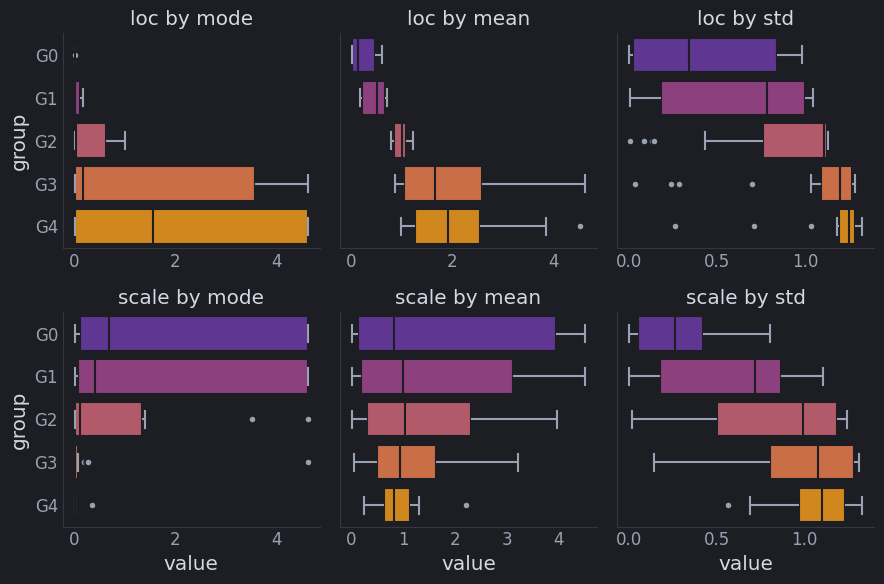

/home/nicholas/programs/rho_plus/rho_plus/util.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  return func(*new_args, **new_kwargs)


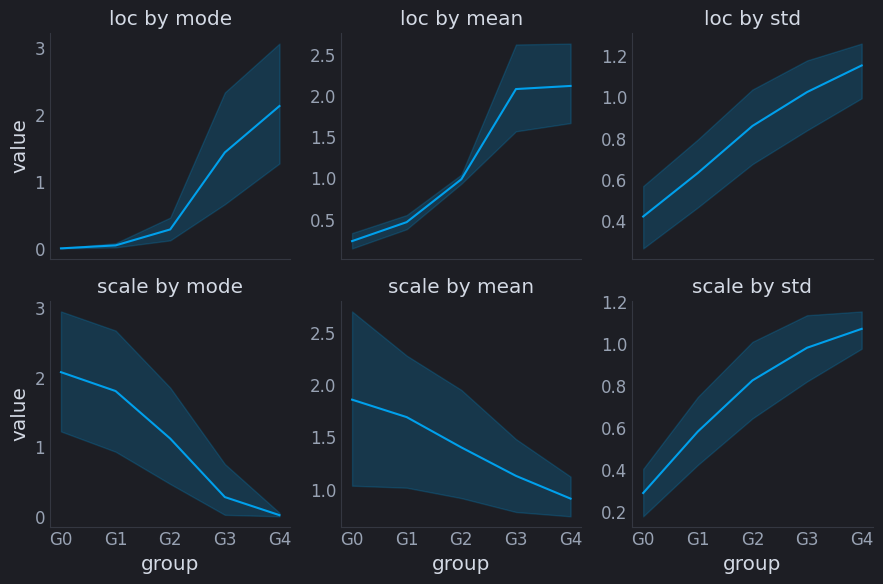

In [ ]:
g = sns.catplot(sdf.reset_index(), row='param', col='stat', y='group', hue='group',
                x='value', kind='box', palette='rho_sequential', legend=None, height=3,
                **rp.boxstyle(), sharex=False)

g.set_titles('{row_name} by {col_name}')
plt.show()

g = sns.relplot(sdf.reset_index(), row='param', col='stat', y='value', x='group', kind='line',
                palette='rho_sequential', legend=None, height=3, facet_kws=dict(sharey=False), estimator='mean')

g.set_titles('{row_name} by {col_name}')

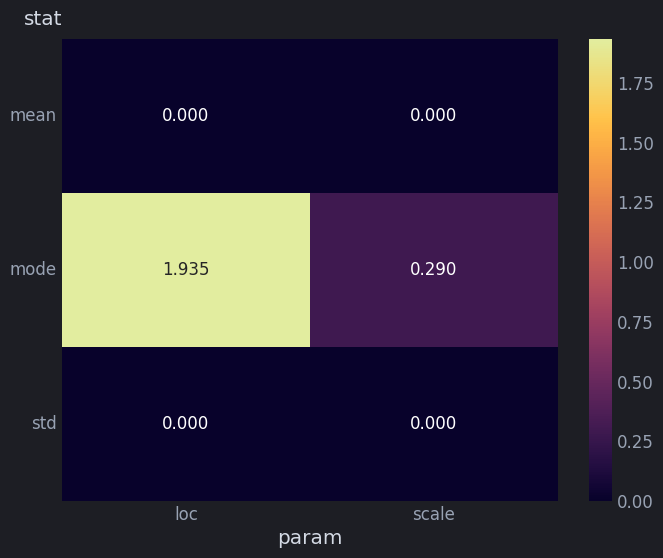

In [ ]:
from scipy.stats import f as fdist
dfn = (space.n_groups - 1)
dfd = (space.n_samples * space.n_groups - space.n_groups)
null_dist = fdist(dfn, dfd)


def exp_kernel(n, bw=0.3):
    kernel = bw ** np.abs(np.arange(n) - np.arange(n).reshape(-1, 1))
    kernel /= kernel.sum(axis=1, keepdims=True)
    return kernel

def single_f_stat(subs, bw=0.3, aggfunc=np.median):
    v = subs[['group', 'value']].groupby('group').median()
    kv = exp_kernel(space.n_groups, bw) @ v
    kv.index = v.index
    avg = kv.loc[subs['group']].values
    err = subs['value'].values - avg.reshape(-1)

    ss_treat = (((kv['value'] - kv['value'].mean()) ** 2) * subs['group'].value_counts()).sum()
    ms_treat = ss_treat / dfn

    ss_err = np.sum(err ** 2)
    ms_err = ss_err / dfd

    F = ms_treat / ms_err

    return F

def plot_pval(data=None, **kwargs):
    subs = data
    xx = np.linspace(0, 10, 1000)
    F = single_f_stat(subs)
    plt.plot(xx, null_dist.pdf(xx), scalex=False, scaley=False)
    plt.fill_between(xx[xx >= F], xx[xx >= F] * 0, null_dist.pdf(xx[xx >= F]),
                     color=cs[1])
    if F <= 10:
        plt.axvline(F, ymax=0.1, color=cs[1])
        plt.text(F + 0.1, 0.1, 'p = {:.04f}'.format(null_dist.sf(F)), c=cs[2])

# g = sns.FacetGrid(sdf.reset_index(), row='param', col='stat')
# g.map_dataframe(plot_pval)
# g.set_titles('{row_name} by {col_name}')
# g.axes[0][0].set_xlim(0, 7)
# g.axes[0][0].set_ylim(0, 0.8)
# plt.show()

f_stats = sdf.reset_index().groupby(['param', 'stat']).apply(single_f_stat)
f_stats.name = 'F'
f_stats = f_stats.unstack()

sns.heatmap(f_stats.T, cmap='rho_heatmap', annot=True, fmt='.3f')
plt.yticks(rotation=0)
rp.ylabel_top()

In [ ]:
def f_stat(space):
    sdf = pop_values(space)
    sdf = sdf.melt(ignore_index=False, var_name='stat')
    f_stats = sdf.reset_index().groupby(['param', 'stat']).apply(single_f_stat)
    f_stats.name = 'F'
    return f_stats.sort_values(ascending=False)

space = ParamSpace(dist.arg_constraints)
fs = []
for _ in range(space.n_params):
    f1 = f_stat(space)
    print(*f1.index[0], f'{f1.iloc[0]:.2f}')
    space.fix(f1.index[0][0], 1)
    fs.append(f1)

loc mode 40.06
scale mode 1259.96


In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

torch_xx = torch.tensor(df_xx.values)
torch_yy = torch.tensor(df_yy).exp()

def gauss_kde(loc: torch.Tensor, bw='scott'):
    if bw == 'scott':
        bw = 0.5 * loc.shape[-1] ** (-1/5)
    return dists.MixtureSameFamily(
        dists.Categorical(torch.ones(loc.shape[-1])),
        dists.Normal(loc, torch.ones_like(loc) * bw)
    )

def fit_param_dist(space: ParamSpace, param: str, stat: str,
                   xdata: torch.Tensor, ydata: torch.Tensor,
                   err_dist=gauss_kde):

    space.unfix(param)

    samples, free_names, free_is = space.free_sample_space()
    param_i = space.param_names.index(param)

    group_i = free_names.index(param)
    samples = samples[group_i, ...]


    n_xx = 100
    supp_trans = dists.transforms.transform_to(dist.support)
    xx = dists.Normal(
        supp_trans.inv(xdata.mean()),
        supp_trans.inv(xdata.max()) - supp_trans.inv(xdata.min())).icdf(
            torch.linspace(0, 1, n_xx+2)[1:-1])
    xx = supp_trans(xx)
    true_stat = pop[stat](xdata, ydata).item()
    sdf = pop_values(space, x=xx)
    sdf['value'] = sdf[stat]
    grps = sdf[['value']].query('param == @param').groupby('group')
    iqr = grps.agg(lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25))
    med = grps.median()
    z_ish_score = (true_stat - med) / (iqr + 1)

    trans = space.theta_transforms[param]
    z_ish_score.index = to_np(trans.inv(space.group_levels[param_i]))
    z_ish_score = z_ish_score.sort_index()

    spl = InterpolatedUnivariateSpline(
        z_ish_score.index,
        z_ish_score.values,
        k=3
    )

    return sdf, true_stat, z_ish_score, to_np(trans(torch.tensor(spl.roots())))


space = ParamSpace(dist.arg_constraints, n_groups=10, n_samples=40, scale=2)

sdfs = []
all_roots = []
fs = []
theta_star = {}
for trial_i in range(space.n_params):
    f1 = f_stat(space)
    print(*f1.index[0], f'{f1.iloc[0]:.2f}')
    sdf, true_stat, z, roots = fit_param_dist(space, *f1.index[0], torch_xx, torch_yy)
    roots.sort()
    sdf[['param', 'stat']] = f1.index[0]
    sdf['true_stat'] = true_stat
    sdf['trial'] = trial_i
    sdfs.append(sdf)
    all_roots.append(roots)
    if len(roots) == 0:
        print('No root found')
        root = space.group_levels[space.param_names.index(f1.index[0][0])].mean()
    else:
        root = roots[(len(roots) - 1) // 2]
    print('{} = {:.2f}'.format(f1.index[0][0], root))
    theta_star[f1.index[0][0]] = root
    space.fix(f1.index[0][0], root)

loc mode 45.47
loc = 2.01
scale mean 1166.35
No root found
scale = 0.86


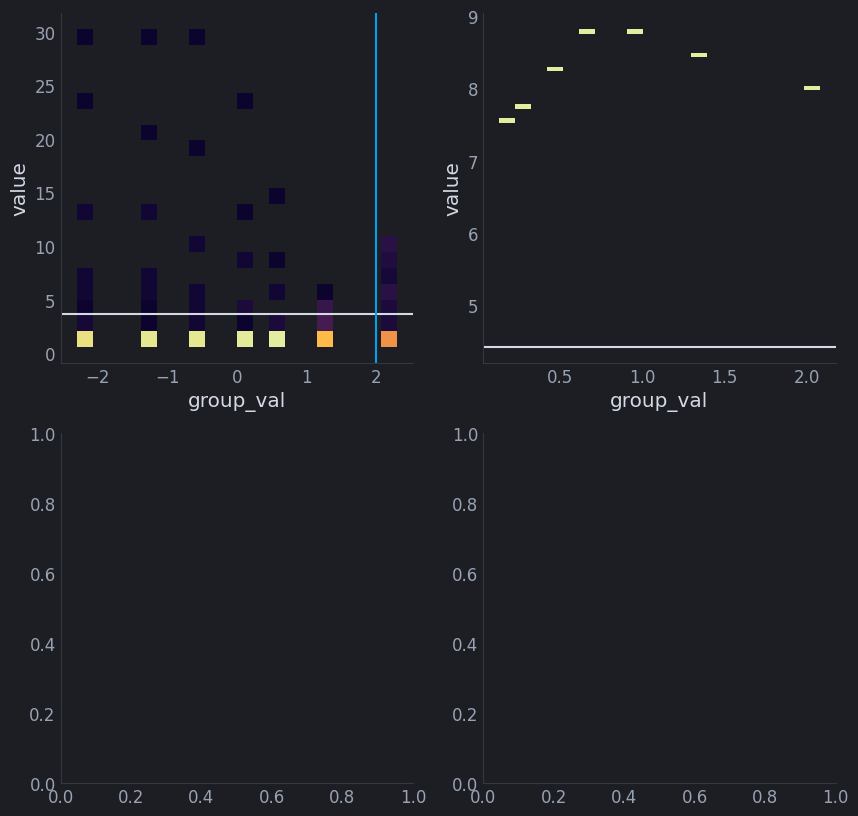

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for sdf, roots, ax in zip(sdfs, all_roots, axs.flatten()):
    levels = to_np(space.group_levels[space.param_names.index(sdf['param'][0])])
    sdf['group_val'] = [levels[int(s[1:])] for s in sdf.index.get_level_values('group')]
    sns.histplot(sdf, x='group_val', y='value', ax=ax, cmap='rho_heatmap', bins=20)
    ax.axhline(sdf['true_stat'].iloc[0], color=plt.rcParams['text.color'])
    for i, r in enumerate(roots):
        if i == (len(roots) - 1) // 2:
            c = cs[0]
        else:
            c = plt.rcParams['text.color']

        ax.axvline(r, c=c)

In [ ]:
from ipywidgets import interact
from ipywidgets import widgets

def interact_params(space: ParamSpace, theta_star):
    widgetdict = {}
    for p, dist in zip(space.param_names, space.param_dists):
        extent = torch.abs(dist.cdf(torch.tensor(theta_star[p])) - 0.5)
        extent = torch.maximum(extent, torch.tensor(0.45))
        widgetdict[p] = widgets.FloatSlider(
            theta_star[p],
            min=dist.icdf(0.5 - extent).item(),
            max=dist.icdf(0.5 + extent).item(),
            step=0.01,
        )
    return widgetdict


target_xx = df_xx.values
target_yy = np.exp(df_yy)
ii = np.argsort(target_xx)
target_xx = target_xx[ii]
target_yy = target_yy[ii]

# xx = torch.linspace(target_xx.min() - target_xx.std(), target_xx.max() + target_xx.std(), 100)
xx = torch.linspace(0.01, 10, 100)
@interact(**interact_params(space, theta_star))
def plot(**kwargs):
    txx, tyy = f(torch.tensor(list(kwargs.values())))(xx)
    plt.plot(
        to_np(txx.squeeze()),
        to_np(tyy.squeeze().exp())
    )
    plt.plot(
        target_xx,
        target_yy
    )
    plt.ylim(0, 0.8)

/tmp/ipykernel_38970/2366065470.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  extent = torch.abs(dist.cdf(torch.tensor(theta_star[p])) - 0.5)


interactive(children=(FloatSlider(value=2.0087253982345032, description='loc', max=3.289707022733046, min=-3.2…

In [ ]:
from torch.fx import symbolic_trace

def target_func(loc, scale, asymmetry, softness, x):
    return dists.SoftAsymmetricLaplace(
        loc, scale, asymmetry, softness,
        validate_args=False
    ).log_prob(x)

symbolic_trace: torch.fx.GraphModule = symbolic_trace(target_func)
symbolic_trace.graph.print_tabular()

opcode         name               target                                                        args                               kwargs
-------------  -----------------  ------------------------------------------------------------  ---------------------------------  --------------------
placeholder    loc                loc                                                           ()                                 {}
placeholder    scale              scale                                                         ()                                 {}
placeholder    asymmetry          asymmetry                                                     ()                                 {}
placeholder    softness           softness                                                      ()                                 {}
placeholder    x                  x                                                             ()                                 {}
call_function  broadcast_tensors  <funct

Other things to try:

- Some kind of a spline or gradient approach to get a better estimate of the stat from the groups using interpolation
- Grid sampling